### Imports

In [23]:
import os
import sys
sys.path.append('../scripts')

import modis
import utils

import numpy as np
import matplotlib.pyplot as plt
import rasterio
import rioxarray as rxr
import earthpy.plot as ep


### Setup

In [24]:
lat_lon = (52.70059156998173, -119.69954537268181)
tiles = modis.get_tile(lat_lon[0], lat_lon[1])

tiles = "h14v03"
start_date = "2021-06-29"
end_date = "2021-08-30"

raw_dir = "../data/modis/raw"
processing_dir = "../data/modis/processing"

### Get data

In [25]:
textfile_path = modis.download_modis(start_date, end_date, tiles=tiles)

In [26]:

textfile_path

'../data/modis/raw/h14v03/listfileMOD14A1.061.txt'

In [27]:
files = modis.get_modis_hdf_filelist(textfile_path)
files

['../data/modis/raw/h14v03/MOD14A1.A2021241.h14v03.061.2021251132424.hdf',
 '../data/modis/raw/h14v03/MOD14A1.A2021233.h14v03.061.2021243201424.hdf',
 '../data/modis/raw/h14v03/MOD14A1.A2021225.h14v03.061.2021234030437.hdf',
 '../data/modis/raw/h14v03/MOD14A1.A2021217.h14v03.061.2021226031841.hdf',
 '../data/modis/raw/h14v03/MOD14A1.A2021209.h14v03.061.2021218012400.hdf',
 '../data/modis/raw/h14v03/MOD14A1.A2021201.h14v03.061.2021213224514.hdf',
 '../data/modis/raw/h14v03/MOD14A1.A2021193.h14v03.061.2021202175017.hdf',
 '../data/modis/raw/h14v03/MOD14A1.A2021185.h14v03.061.2021194012533.hdf']

### Extracting the fire mask

In [28]:
for file_path in files:
    firemask, date_objects, fire_filename = modis.extract_fire_mask(file_path)


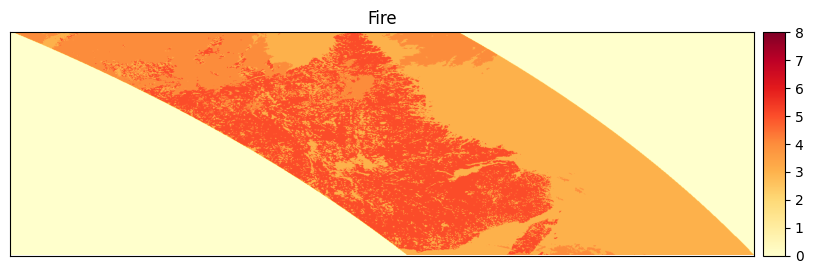

<Axes: title={'center': 'Fire'}>

In [29]:
fire = rasterio.open(fire_filename)
ep.plot_bands(fire.read(1), title="Fire", cmap="YlOrRd", figsize=(10, 10))

### Cropping based on a bounding box

In [30]:
coords, pixels = modis.get_coords_and_pixels(fire)
bbox_coords = utils.create_bounding_box(coords)
modis_cropped_path = modis.crop(fire_filename, bbox_coords)

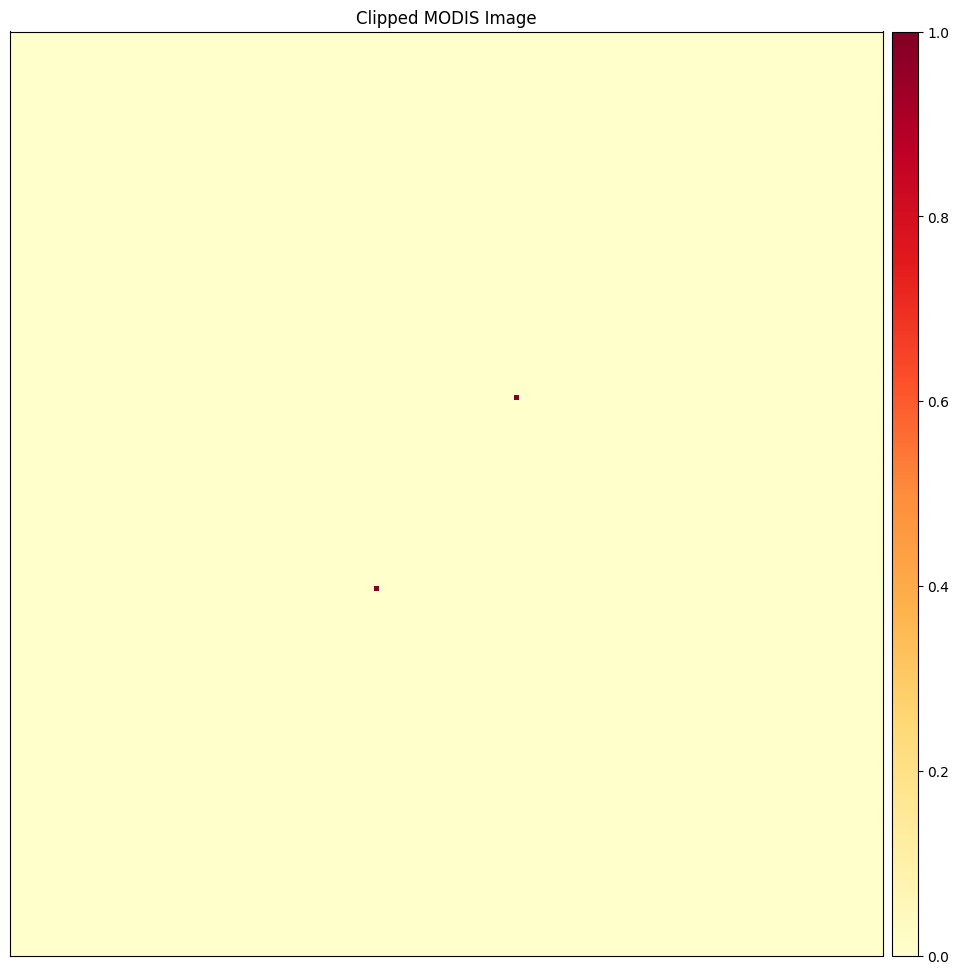

<Axes: title={'center': 'Clipped MODIS Image'}>

In [31]:
# open the cropped MODIS image
cropped_modis = rasterio.open(modis_cropped_path)

# Plot the clipped MODIS image
ep.plot_bands(cropped_modis.read(1) > 6, title="Clipped MODIS Image", cmap="YlOrRd")

### Resizing the modis file

In [37]:
file = modis.resize(modis_cropped_path, output_dir="../data/modis/final")

In [33]:
# Open the resized MODIS image
tiff_file = rxr.open_rasterio(file)
tiff_file.shape

(8, 128, 128)

In [34]:
results = modis.get_weather(file, date_objects)

Processing data for date: 2021-07-04 00:00:00


  0%|          | 0/128 [00:00<?, ?it/s]

100%|██████████| 128/128 [17:24<00:00,  8.16s/it]


Processing data for date: 2021-07-05 00:00:00


100%|██████████| 128/128 [09:36<00:00,  4.50s/it]


Processing data for date: 2021-07-06 00:00:00


100%|██████████| 128/128 [09:37<00:00,  4.51s/it]


Processing data for date: 2021-07-07 00:00:00


100%|██████████| 128/128 [09:39<00:00,  4.52s/it]


Processing data for date: 2021-07-08 00:00:00


100%|██████████| 128/128 [09:33<00:00,  4.48s/it]


Processing data for date: 2021-07-09 00:00:00


100%|██████████| 128/128 [09:45<00:00,  4.57s/it]


Processing data for date: 2021-07-10 00:00:00


100%|██████████| 128/128 [26:38<00:00, 12.49s/it]  


Processing data for date: 2021-07-11 00:00:00


100%|██████████| 128/128 [09:28<00:00,  4.44s/it]


Number of pixels with no data:  116511
Number of pixels with no data:  118315
Number of pixels with no data:  116809
Number of pixels with no data:  116796


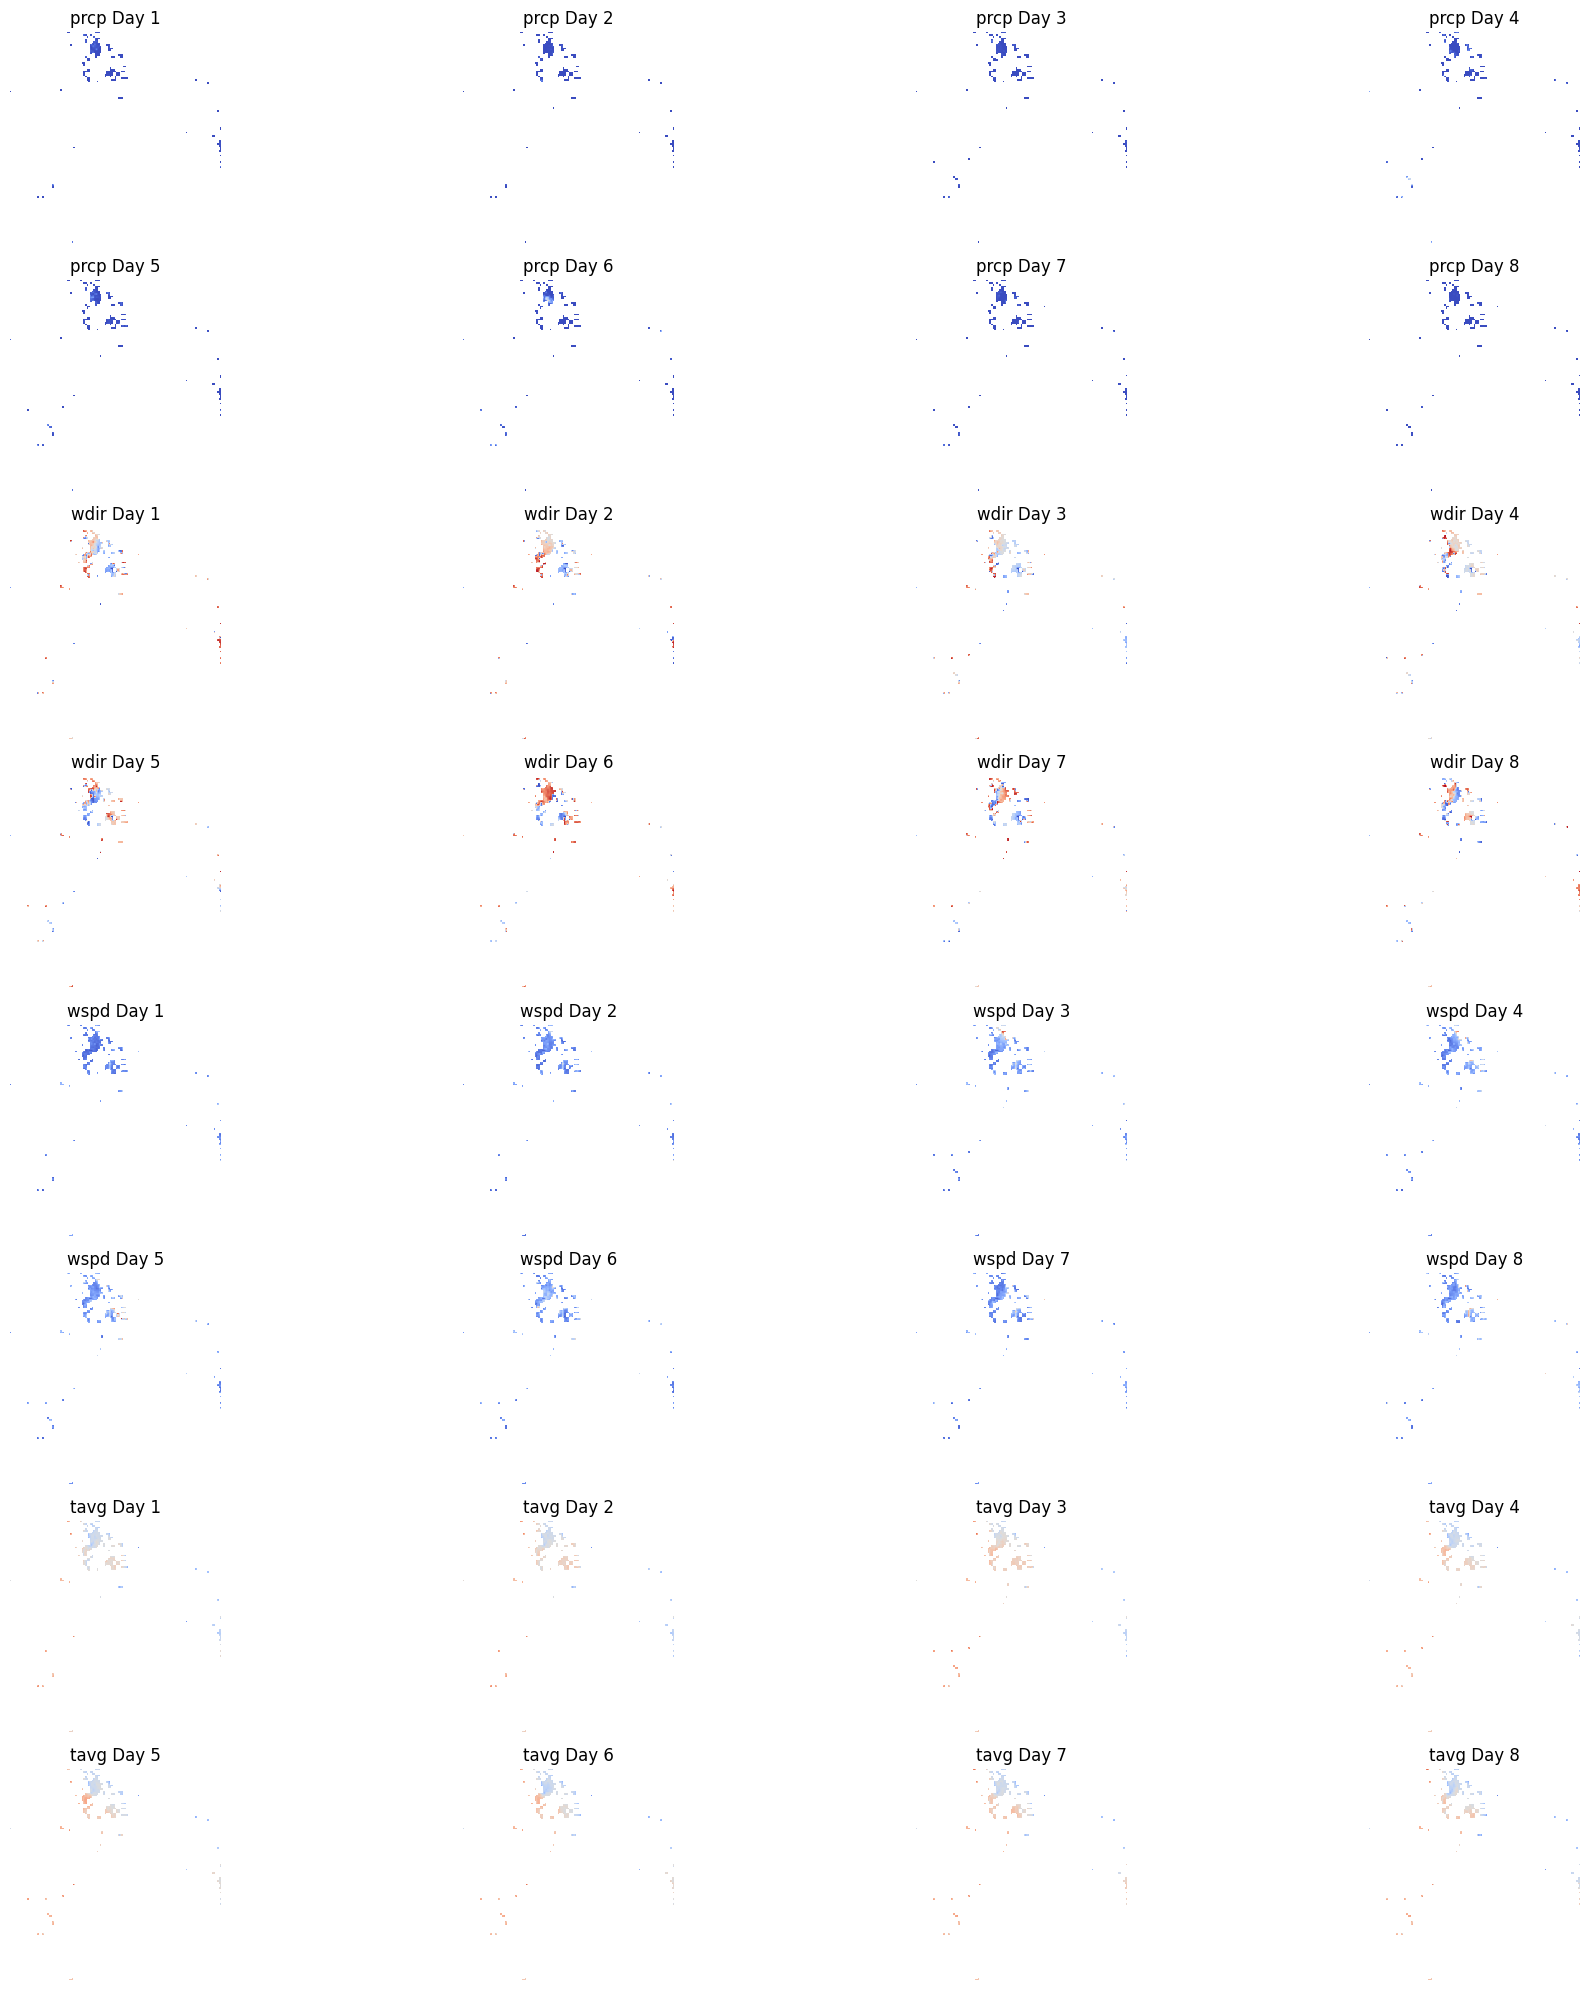

In [47]:
# count the number of pixels with no data

for data in results.values():
    print("Number of pixels with no data: ", np.isnan(data).sum())

# plot the data
fig, axes = plt.subplots(8, 4, figsize=(20, 20))
axes = axes.ravel()

# plot the 8 days of data for each variable
for i in range(0, 8):
    for j, key in enumerate(results.keys()):
        axe_nb = i + (j - 1) * 8
        axes[axe_nb].imshow(results[key][i], cmap="coolwarm")
        axes[axe_nb].set_title(f"{key} Day {i + 1}")
        axes[i + (j - 1) * 8].axis("off")



plt.tight_layout()
plt.show()